# Extracting Building Footprints From Drone Data
## Introduction

Building footprints is a required layer in lot of mapping exercises, for example in Basemap preparation, humantitarian aid and disaster management, transportation and a lot of other applications it is a critical component.Traditionally gis analysts digitize building footprints by looking at the imagery and drawing polygon around it.

This Sample shows how arcgis python api can be used to train a deep learning model to extract building footprints from drone data. The models trained can be used with ArcGIS Pro or ArcGIS Enterprise and even support distributed processing for quick results.

The data used in this sample originates from USAA and covers the region effected by woolsey fires.


## Export Data for Training

Training data can be exported using the `Export Training Data For Deep Learning` tool available in <a href="https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm">ArcGIS Pro</a> as well as <a href="https://developers.arcgis.com/rest/services-reference/export-training-data-for-deep-learning.htm">ArcGIS Enterprise</a>.<br/>For this example we exported training data in `Classified Tiles` format using a `chip_size` of 400px and `cell_size` of 30cm in ArcGIS Pro. 



Steps Involved:

1. Rasterize building footprints using <a href="https://pro.arcgis.com/en/pro-app/tool-reference/conversion/polygon-to-raster.htm">`Polgon to Raster`</a> tool.
<div>
    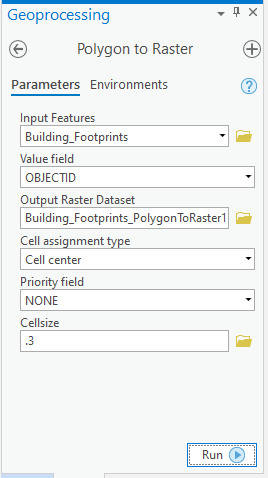
</div>


2. Convert all NoData values to `0` and other values to `1` using <a href="https://pro.arcgis.com/en/pro-app/tool-reference/3d-analyst/an-overview-of-the-raster-reclass-toolset.htm">`Reclassify Raster`</a> tool.
  <br><br/>After selecting input raster click on `classify` and set only one class. For the class with `valid data range` Set `New` value to `1` for `NoData` set `New` value to `0`.
<div>
    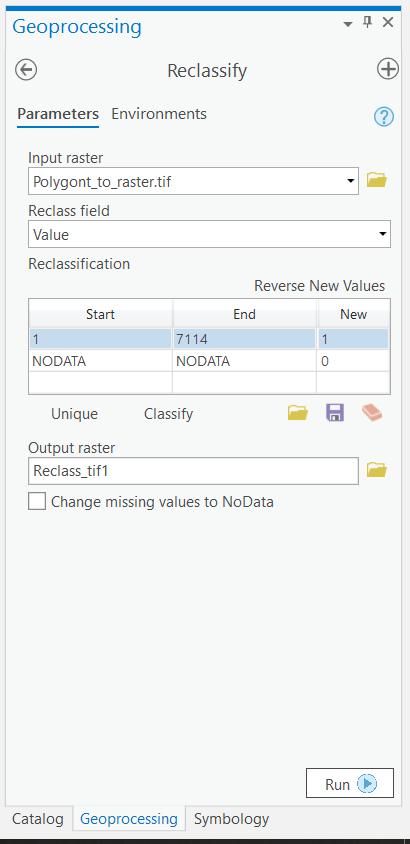
</div>

3. Export the reclassified raster to a `8bit unsigned` raster.
<div>
    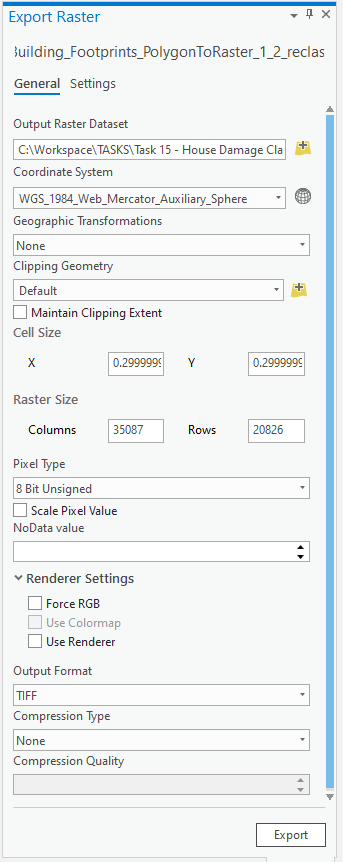
</div>


4. Change the raster to a themetic raster.
    - Open `Catalog Pane` > navigate to the raster you just exported > Right Click and select `Properties`.
    - In the `Raster Properties` pane change the source type to `Themetic`.
<div>
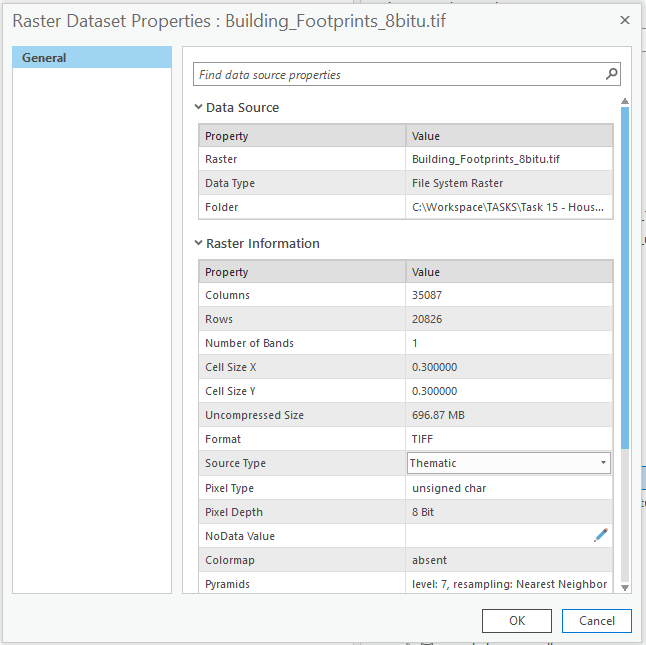
</div>



5. Export training data using `Export Training data for deep learning` tool, <a href="https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/export-training-data-for-deep-learning.htm">detailed documentation here</a>.
    - Set drone imagery as `Input Raster`.
    - Set a location where you want to export the training data, it can be an existing folder or the tool will create that for you.
    - Set classified raster as `Input Feature Class Or Classified Raster`.
    - In the option `Input Mask Polygons` we can set a mask layer to limit the tool to export training data for only those areas which have buildings in it, we created one by generating a grid of 200m by 200m on building footprint layer's extent and dissolving only those polygons which contained buildings to a single multipolygon feature.
    - `Tile Size X` & `Tile Size Y` can be set 
    - Select `Classified Tiles` as the `Meta Data Format` because we are training an `Unet Model`.
    - In `Environments` tab set an optimum `Cell Size` which is small enough to allow model to learn the texture of building roofs by the details and big enough to allow multiple buildings to fall in one tile and model can also understand the surrounding context of the buildings. For this example we used 0.3 cell size which meant 30cm on a project coordinate system. 
<div>
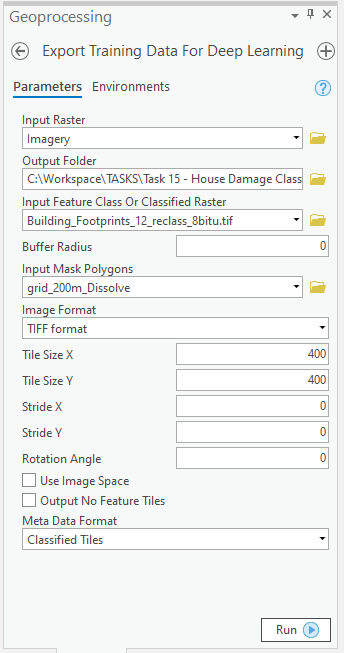
<br/>
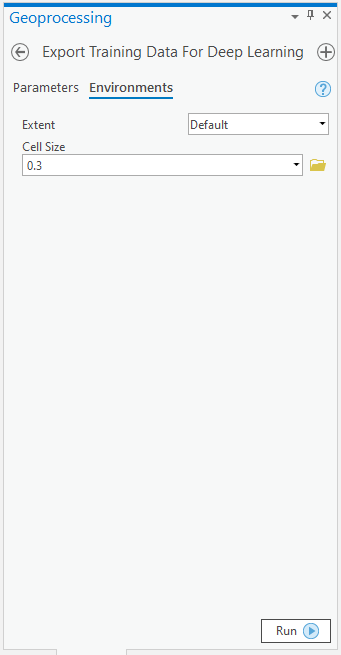
</div>

This will create all the necessary files needed for the next step will in the `Output Folder`, this is our training data.

## Train the Model

This step would be done using jupyter notebook and documentation is available <a href="https://developers.arcgis.com/python/guide/install-and-set-up/"> here to `install and setup environment`</a>. 

### Import all the libraries


In [2]:
import arcgis
from arcgis.learn import prepare_data


### Prepare Data

We would specify the path to our training data and a few hyper parameters.

path: path of folder containing training data.<br/>
chip_size: Same as per specified while exporting training data<br/>
batch_size: No of images your model will train on each step inside an epoch, it directly depends on the memory of your graphic card. 8 worked for us on a 11GB GPU.

In [5]:
# Prepare Data
data = prepare_data(
    r'Data\Training Data 400px 30cm mask 0,1 classes',
    chip_size=400, 
    batch_size=8,
)


### Visualise few samples from your Training data
The code below shows few samples of our data with the same symbology as in ArcGIS Pro.

rows: No of rows we want to see the results for.<br>
alpha: controls the opacity of labels(Classified imagery) over the drone imagery

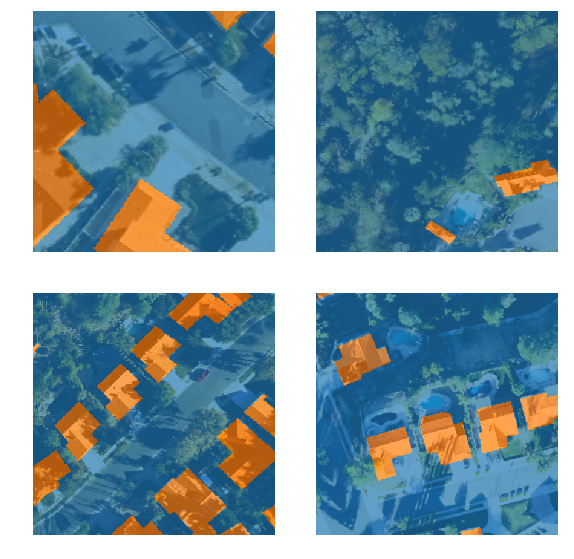

In [6]:
data.show_batch(rows=2, alpha=0.7)

### Load an `UnetClassifier` model

The Code below will create an `UnetClassifier` model, it is based on a state of art deep learning model ardchitecture `U-net`. This type of model is used where `pixel wise segmention` or in GIS terminology `imagery classification` is needed, by default this model will be loaded on a pretrained `resnet` backbone.  

In [7]:
# Create Unet Model
model = arcgis.learn.models.UnetClassifier(data)

### Find an `Optimal Learning Rate`

Optimization in deep learning is all about tuning `hyperparameters`, in this step we will find an `optimum learning rate` for our model on the training data. This will enable us to train our model just fast enough to save our time. 

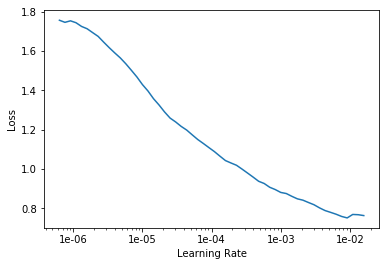

In [ ]:
# Find Learning Rate
model.lr_find()

Looking at the above graph we see that loss continously decreases after 1e-03 or .001 so that can be set the highest learning rate and lowest learning rate a tenth of it.

### Fit the model

We would start by 30 epochs.

In [13]:
# Training
model.fit(30, lr=slice(0.0001, 0.001))


epoch,train_loss,valid_loss,accuracy
1,0.380910,0.240573,0.903260
2,0.280911,0.186109,0.924779
3,0.239853,0.174129,0.928293
4,0.217517,0.210512,0.917524
5,0.230968,0.214885,0.916372
6,0.230243,0.150260,0.944047
7,0.209158,0.163510,0.937708
8,0.237564,0.214373,0.926745
9,0.252157,0.176768,0.924209
10,0.235220,0.190232,0.933598


### Save the model

We would now save the model which we just trained, this saved model will be used to extract building footprints by the tool `Classify Pixels Using Deep Learning` available in <a href="https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm">ArcGIS Pro</a> as well as <a href="https://developers.arcgis.com/rest/services-reference/classify-pixels-using-deep-learning-.htm">ArcGIS Enterprise</a>. 

By default it will save to a folder `models` inside our training data folder.

In [14]:
# Save model to file
model.save('30e')

WindowsPath('Data/Training Data 400px 30cm mask 0,1 classes/models/30e')

### Load an Intermediate model

If we need to further train an already saved model we can load it again using the code below and go back to <a href="#Train-the-model">`Train the model`</a> step and further train it.

In [2]:
# Load Model from previous saved files 

# model.load('30e')


### Preview Results

The code below will pick a few random samples and show us ground truth and respective model predictions side by side. This allows us to preview the results of your model in the notebook itself, once satisfied we can save the model and use it further in our workflow.

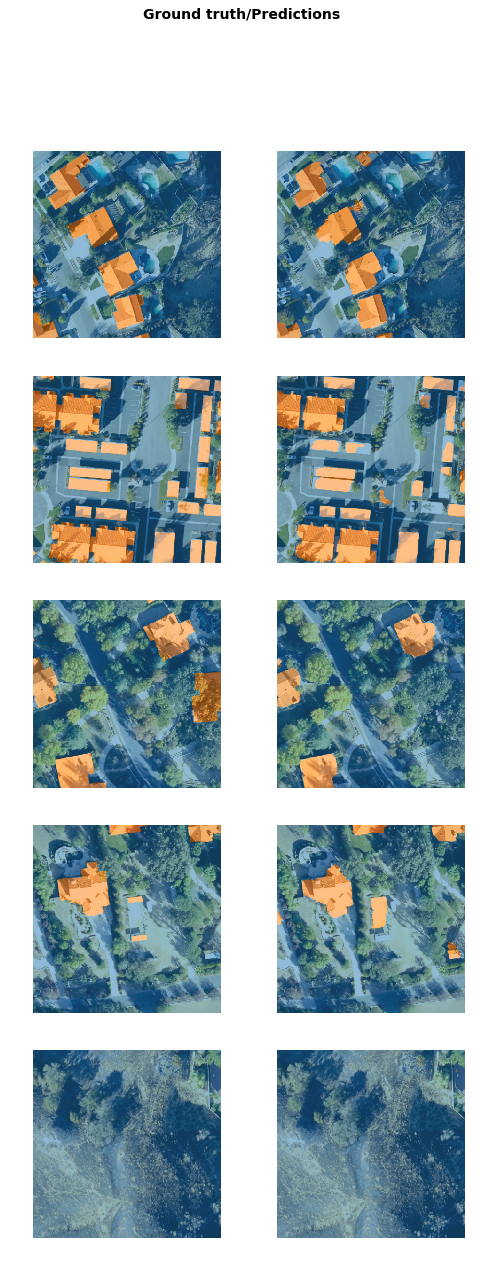

In [10]:
# Preview Results
model.show_results()

## Extract Footprints

The deep learning model saved in previous step can be used to extract classfied raster using `Classify Pixels Using Deep Learning` tool.
Further the classfied raster is regularised and finally converted to a vector Polygon layer. The regularisation step uses advanced arcgis geoprocessing tools to remove unwanted artifacts in the output. 

### Generate a `Classified Raster` using `Classify Pixels Using Deep Learning` tool

In this step we will generate a classfied raster using `Classify Pixels Using Deep Learning` tool available in both <a href="https://pro.arcgis.com/en/pro-app/tool-reference/image-analyst/classify-pixels-using-deep-learning.htm">`ArcGIS Pro`</a> and <a href="https://developers.arcgis.com/rest/services-reference/classify-pixels-using-deep-learning-.htm">`ArcGIS Enterprise`</a>.

- Input Raster: The raster layer from which we want to extract building footprints from.
- Model Definition: It will be located inside the saved model in `models` folder in `.emd` format.
- padding: The `Input Raster` is tiled and the deep learning model classifies each individual tile separately before producing the final `Output Classified Raster`. This may lead to unwanted artifacts along the edges of each tile as the model has little context to predict accuratly. Padding as the name suggests allows us to supply some extra information along the tile edges, this helps the model to predict better. 
- Cell Size: Should be close to at which we trained the model, we specified that at the <a href="#Export-Data-for-Training"> `Export Data for Training`</a> step.
- Processor Type: This allows to control wether the system's `GPU` or `CPU` would be used in to classify pixels, by `default GPU` will be used if available.
- Parallel Processing Factor: This allows us to scale this tool, this tool can be scaled on both `CPU` and `GPU`. It specifies that the opration would be spread across how many `cpu cores` in case of cpu based operation or `no of GPU's` incase of GPU based operation.
<div>
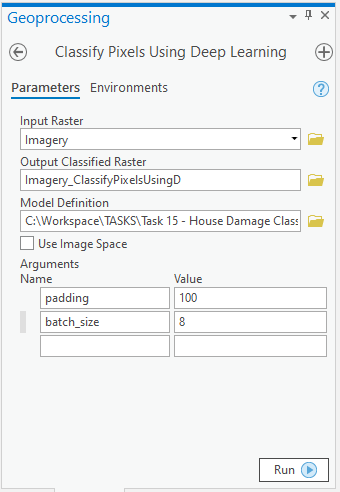
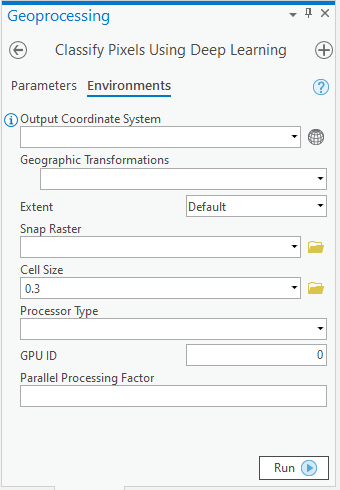
</div>


Output of this tool will be in form of a `classified raster` containing both background and building footprints.
<div>
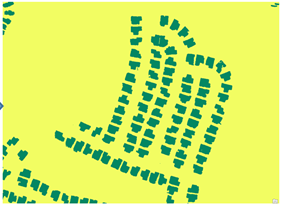
</div>

###  Streamline postprocessing workflow using model builder

As postprocessing workflow below involves quite a few tools and the parameters set in these tools need to be experimented with to get optimum results. We would use model builder to streamline this for us and enable us iteratively change the parameters in this workflow. 

<div>
    <br/>
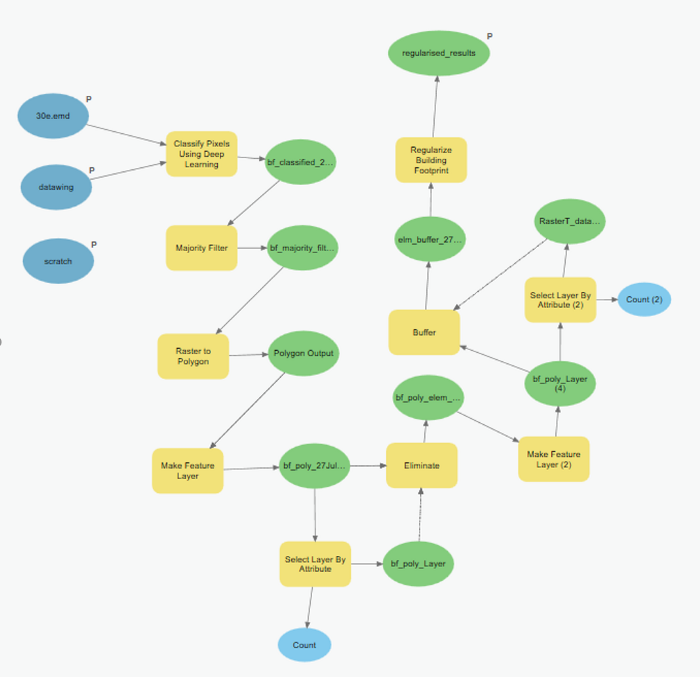
</div>




Tools used and important parameters:
- Majority Filter: `Reduces noise` in the classified raster, we would use `four` neighbouring cells majority to smoothen the raster.
- Raster to Polygon: Vectorizes raster to polygon based on cell values, we will keep the `Simplify Polygons` and `Create Multipart Features` options `unchecked`.
- Eliminate: Removes selected records by merging them into nieghbouring features, we selected features `below 10 sqm Area` before using this tool to remove small unwanted noise that  Vectorizes raster to polygon based on cell values, we will keep the `Simplify Polygons` and `Create Multipart Features` options `unchecked`.
- Buffer: To slightly increase coverage of buildings we would buffer them by `5cm`. Before buffering them we would select only building features this will remove background features from output of this tool.
- Regularize Building Footprints: This tool will produce the final finished results by shaping them to how actual buildings look. `Method` for regularisation would be `Right Angles and Diagnols` and the parameters `tolerance`, `Densification` and `Precision` are `1.5`, `1`, `0.25` and `2` respectively. 

### Final Output

The final output will be in form of a feature class.

<div>
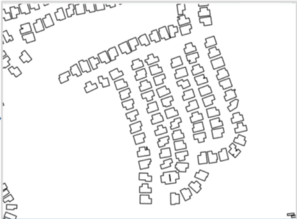
</div>